### Multi-Label classification

In [4]:
%reload_ext autoreload
%autoreload
%matplotlib inline

In [5]:
from fastai import*
from fastai.vision import*

In [6]:
torch.cuda.set_device(3)

In [10]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

In [11]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/deep/.fastai/data/planet')

In [25]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
! unzip -q -n {path}/train_v2.csv.zip -d {path}

train-jpg.tar.7z: Skipping, found more recently modified local copy (use --force to force download)
train_v2.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [26]:
! conda install --yes --prefix {sys.prefix} -c haasad eidl7zip

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - eidl7zip


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.9.11          |           py36_0         154 KB
    eidl7zip-1.0.0             |                1         565 KB  haasad
    openssl-1.1.1d             |       h7b6447c_2         3.7 MB
    ------------------------------------------------------------
                                           Total:         4.4 MB

The following NEW packages will be INSTALLED:

  eidl7zip           haasad/linux-64::eidl7zip-1.0.0-1

The following packages will be UPDATED:

  openssl            conda-forge::openssl-1.1.1c-h516909a_0 --> pkgs/main::openssl-1.1.1d-h7b6447c_2

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi                                       conda-forge --> pkgs/main



o

In [27]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}


7-Zip (A) [64] 9.20  Copyright (c) 1999-2010 Igor Pavlov  2010-11-18
p7zip Version 9.20 (locale=C,Utf16=off,HugeFiles=on,32 CPUs)

Processing archive: /home/deep/.fastai/data/planet/train-jpg.tar.7z

Extracting  train-jpg.tar

Everything is Ok

Size:       665753600
Compressed: 629296207


### Multiclassification

In [28]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [54]:
tfms=get_transforms(flip_vert=True, max_lighting=0.1,max_zoom=1.05,max_warp=0.) #data augmentation

In [55]:
np.random.seed(42)
#Creating the dataset:
src=(ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [56]:
#create dataloader and databung in one go ---> Data Block API
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

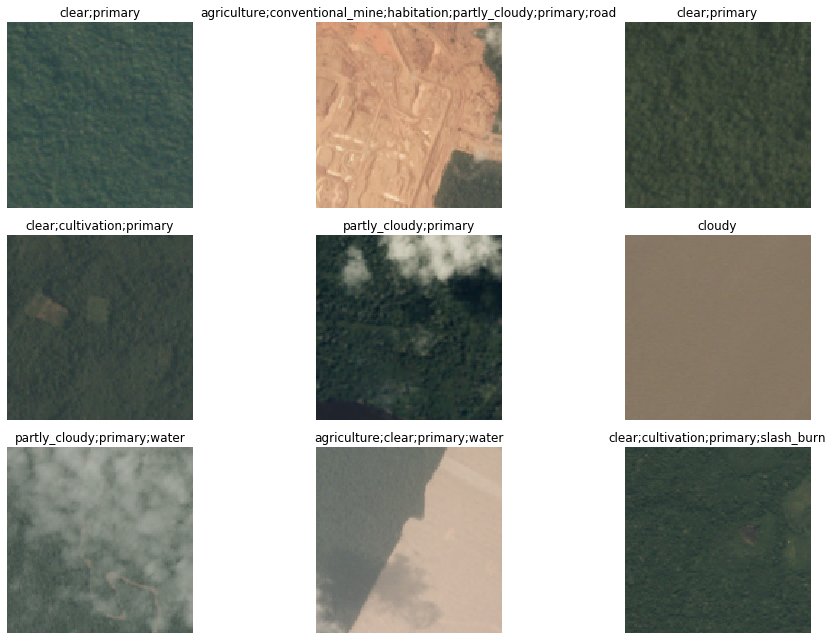

In [57]:
data.show_batch(rows=3, figsize=(12,9))

To create a Learner we use the same function as in lesson 1. Our base architecture is resnet50 again, but the metrics are a little bit differeent: we use accuracy_thresh instead of accuracy. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. accuracy_thresh selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

In [58]:
arch=models.resnet50

In [59]:
acc_02=partial(accuracy_thresh,thresh=0.5) #partial promotes exactly the same function as accuracy_thresh but with a threshold of 0.2
f_score=partial(fbeta,thresh=0.2)
learn=cnn_learner(data,arch,metrics=[acc_02, f_score])

In [60]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


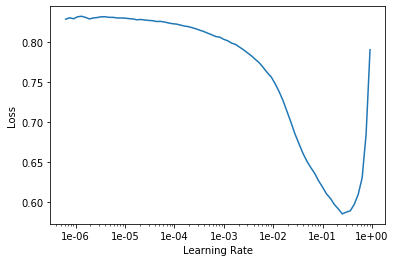

In [61]:
learn.recorder.plot()

In [63]:
lr=0.01

In [64]:
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.126244,0.110983,0.957345,0.901655,00:39
1,0.111660,0.097181,0.963172,0.915237,00:39
2,0.099915,0.092091,0.964510,0.920211,00:39
3,0.096197,0.087915,0.965984,0.923687,00:39
4,0.092747,0.086546,0.966384,0.925432,00:40


In [65]:
learn.save('stage-1-rn50')

In [67]:
learn.unfreeze()

In [69]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


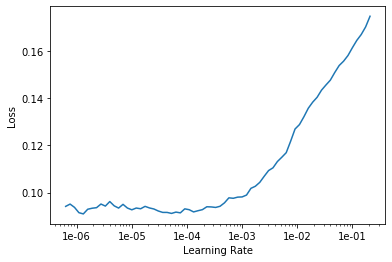

In [70]:
learn.recorder.plot()

In [73]:
learn.fit_one_cycle(5,slice(1e-5,lr/5)) #1e-5-->quando comeca a subir -10x,a outra parte da fatia é mesmo assim lr /5 ou /10

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.083288,0.087067,0.966239,0.925442,00:52
1,0.089075,0.085882,0.966937,0.925383,00:53
2,0.085510,0.085293,0.967119,0.925677,00:54
3,0.079373,0.082866,0.967867,0.929834,00:55
4,0.077148,0.082989,0.968187,0.929153,00:55


In [75]:
learn.save('stage-2-rn50')

In [79]:
#create a new databunch based on the other one but with size=256 -->Transfer Learning
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))
learn.data=data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [80]:
learn.freeze() #train the last few layers

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


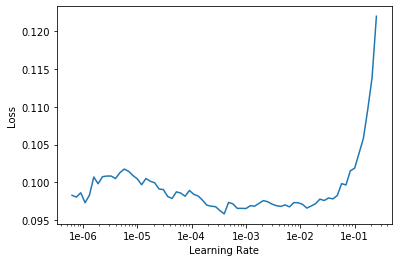

In [81]:
learn.lr_find()
learn.recorder.plot()

In [83]:
lr=1e-2/2

In [84]:
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.084526,0.085136,0.967184,0.924634,02:08
1,0.086528,0.083138,0.967518,0.927867,02:10
2,0.082908,0.082157,0.968019,0.927304,02:10
3,0.078775,0.081328,0.968543,0.929576,02:10
4,0.078624,0.080904,0.968899,0.930658,02:10


In [85]:
learn.save('stage-1-256-rn60')

In [86]:
learn.unfreeze()

In [87]:
learn.fit_one_cycle(5,slice(1e-5,lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.082114,0.082507,0.968049,0.929292,02:54
1,0.083710,0.083089,0.967867,0.927984,02:53
2,0.079708,0.082282,0.968136,0.929509,02:53
3,0.076390,0.081400,0.968688,0.930645,02:53
4,0.071527,0.081460,0.968492,0.931116,02:53


In [88]:
learn.fit_one_cycletage-2-256-rn50')